<a href="https://colab.research.google.com/github/ab7289-tandon-nyu/GraphVision/blob/oscar1/notebooks/oscar_GraphConv_classify_MNISTSuperpixels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main source:

PyG <br>
-> Colab Notebooks And Video Tutorial <br>
-> PyG: 9 Colab notebooks <br>
-> **3. Graph Classification with Graph Neural Networks** <br> (https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing)

## Install and Import

In [1]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

1.13.0+cu116


In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 9.4 MB 47.1 MB/s 
     |████████████████████████████████| 4.6 MB 27.4 MB/s 
     |████████████████████████████████| 280 kB 33.7 MB/s 


## Data

### Download dataset

In [4]:
from torch_geometric.datasets import MNISTSuperpixels

dataset = MNISTSuperpixels(root='data/MNISTSuperpixels')

Extracting data/MNISTSuperpixels/raw/MNISTSuperpixels.zip
Processing...
Done!


In [5]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs  : {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes : {dataset.num_classes}')

Dataset: MNISTSuperpixels(60000):
Number of graphs  : 60000
Number of features: 1
Number of classes : 10


### Split dataset into TRAIN vs TEST

In [6]:
torch.manual_seed(12345)

dataset = dataset.shuffle()

train_dataset = dataset[     :50000]
test_dataset  = dataset[50000:]

print(f'Number of TRAIN graphs: {len(train_dataset)}')
print(f'Number of TEST  graphs: {len(test_dataset)}')

Number of TRAIN graphs: 50000
Number of TEST  graphs: 10000


### Mini-batch the graphs

In [7]:
BATCH_SIZE = 200

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True )
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# for step, data in enumerate(train_loader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print()

## Model

In [9]:
import torch.nn.functional as F

from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch.nn           import Linear

# precondition: the "dataset" object already exists
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels,           hidden_channels)
        self.conv3 = GraphConv(hidden_channels,           hidden_channels)
        self.lin   = Linear(   hidden_channels,           dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1` node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2` graph embedding: the Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3` a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GraphConv(1, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=10, bias=True)
)


## Train, test

### Train, test

In [10]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model     = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(): # (returns nothing)
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out  = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

# 2022.12/7(3)_p04.00: 35 min / 20 epochs = 1.75 min / epoch
NUM_EPOCHS = 20
train_accs = {}
test_accs  = {}
for epoch in range(1, NUM_EPOCHS):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accs[epoch] = train_acc
    test_accs[epoch]  = test_acc
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.2414, Test Acc: 0.2366
Epoch: 002, Train Acc: 0.2669, Test Acc: 0.2639
Epoch: 003, Train Acc: 0.2697, Test Acc: 0.2656
Epoch: 004, Train Acc: 0.2690, Test Acc: 0.2707
Epoch: 005, Train Acc: 0.2683, Test Acc: 0.2671
Epoch: 006, Train Acc: 0.2823, Test Acc: 0.2820
Epoch: 007, Train Acc: 0.2793, Test Acc: 0.2793
Epoch: 008, Train Acc: 0.2839, Test Acc: 0.2827
Epoch: 009, Train Acc: 0.3034, Test Acc: 0.3040
Epoch: 010, Train Acc: 0.3016, Test Acc: 0.3021
Epoch: 011, Train Acc: 0.2947, Test Acc: 0.2980
Epoch: 012, Train Acc: 0.3026, Test Acc: 0.3033
Epoch: 013, Train Acc: 0.3135, Test Acc: 0.3156
Epoch: 014, Train Acc: 0.3478, Test Acc: 0.3426
Epoch: 015, Train Acc: 0.3920, Test Acc: 0.3901
Epoch: 016, Train Acc: 0.4050, Test Acc: 0.4049
Epoch: 017, Train Acc: 0.4018, Test Acc: 0.4021
Epoch: 018, Train Acc: 0.3874, Test Acc: 0.3923
Epoch: 019, Train Acc: 0.3836, Test Acc: 0.3840


### Visualize accuracies

In [11]:
import pandas as pd

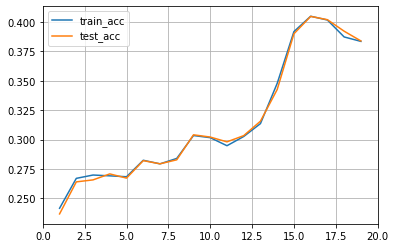

In [12]:
pd.concat((pd.Series(train_accs).rename('train_acc'),
           pd.Series(test_accs).rename('test_acc')),
          axis = 1)\
.plot(grid = True, xlim = (0, NUM_EPOCHS))